In [2]:
import random
import pickle
import numpy as np
import tqdm.auto as tqdm

from torch.nn.modules.loss import _WeightedLoss
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.tensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import torchvision.models as models

from scipy.spatial import distance
from medpy import metric
from collections import Counter

 ### Set the device: cpu or gpu

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


### Load the data

In [4]:
with open('/glade/u/home/gwallach/goes16ci/FiguresModelsForGOES16ci/Data/PickleFiles/train_data_scaled.pkl','rb') as f:
    x = pickle.load(f)

In [5]:
print("Saved shape:", x.shape)
x = x.transpose(0,3,1,2)
print("Reshaped to:", x.shape)

Saved shape: (151246, 32, 32, 4)
Reshaped to: (151246, 4, 32, 32)


In [9]:
with open('/glade/u/home/gwallach/goes16ci/FiguresModelsForGOES16ci/Data/PickleFiles/train_counts.pkl','rb') as f:
    y = pickle.load(f)

In [10]:
#Get indices of all the no-lightning images
#Then find the channel-wise mean for the images that are classified as zero
zero_idx = np.argwhere(y.squeeze() == 0).squeeze()
chan1_mean = np.mean(x[zero_idx, 0, :, :].flatten())
chan2_mean = np.mean(x[zero_idx, 1, :, :].flatten())
chan3_mean = np.mean(x[zero_idx, 2, :, :].flatten())
chan4_mean = np.mean(x[zero_idx, 3, :, :].flatten())
print(chan1_mean, chan2_mean, chan3_mean, chan4_mean)


0.3516034 0.32930115 0.28836843 0.36770383


In [11]:
#Create a baseline tensor for use in Integrated Gradients
tensor = torch.tensor((), dtype=torch.int32)
base_zero= torch.zeros([4, 32, 32])
base_zero[0] = tensor.new_full((32, 32), 0.3516034)
base_zero[1] = tensor.new_full((32, 32), 0.32930115) 
base_zero[2] = tensor.new_full((32, 32), 0.28836843)
base_zero[3] = tensor.new_full((32, 32), 0.36770383)

In [12]:
print("Saved shape:", y.shape)
y = y.reshape(y.shape[0], 1)
print("Reshaped to:", y.shape)

Saved shape: (151246,)
Reshaped to: (151246, 1)


### Subsample the data 

In [ ]:
# gt0 = list(np.where(y >= 1)[0])
# lt0 = list(np.where(y < 1)[0])
# take_a_sample = random.sample(lt0, 10)

# sample = gt0 + take_a_sample

# x = x[sample]
# y = y[sample]



### Split the data into train / test partitions (80 / 20 split)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size=0.2, random_state = 5000
)

##### Create a histogram of the (log) counts

<ipython-input-14-e2a65150e9f1>:1: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.log(Y_train),bins=range(200))


(0.0, 50.0)

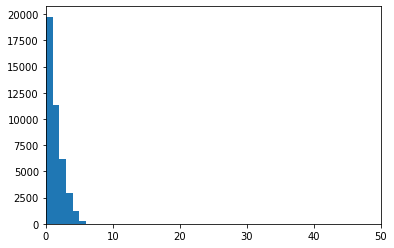

In [14]:
plt.hist(np.log(Y_train),bins=range(200))
plt.xlim([0,50])

##### Create labels for binned lightning counts 

In [15]:
bins = [10, 100]

y_train = np.where(Y_train[:] > 0.0, 1, 0)
y_test = np.where(Y_test[:] > 0.0, 1, 0)

for p,q in enumerate(bins):
    y_train = np.where(Y_train[:] >= q, p+2, y_train)
    y_test = np.where(Y_test[:] >= q, p+2, y_test)

In [16]:
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)
X_IG = X_test
Y_IG = y_test

(120996, 1)
(30250, 1)
(120996, 4, 32, 32)
(30250, 4, 32, 32)


In [18]:
#Sample thirty of each of the classes for use in Integrated Gradients
#First get all the indeces for each class then sample twenty images from each
random_size =30
zero_idx = np.argwhere(y_test.squeeze() == 0).squeeze()
zero_randomidx = np.random.choice(zero_idx, size=30, replace=False )

one_idx = np.argwhere(y_test.squeeze() == 1).squeeze()
one_randomidx = np.random.choice(one_idx, size=30, replace=False )

two_idx = np.argwhere(y_test.squeeze() == 2).squeeze()
two_randomidx = np.random.choice(two_idx, size=30, replace=False )

three_idx = np.argwhere(y_test.squeeze() == 3).squeeze()
three_randomidx = np.random.choice(three_idx, size=30, replace=False )

all_randomidx = np.concatenate((zero_randomidx, one_randomidx, two_randomidx, three_randomidx))


### Create class weights based on counts 

In [19]:
counts = Counter()
for val in y_train:
    counts[val[0]] += 1
counts = dict(counts)


#weights = [1 - (counts[x] / sum(counts.values())) for x in sorted(counts.keys())]
weights = [np.log1p(max(counts.values()) / counts[x]) for x in sorted(counts.keys())]
weights = [x / max(weights) for x in weights]
weights = torch.FloatTensor(weights).to(device)

print(weights)

tensor([0.1438, 0.2546, 0.4937, 1.0000], device='cuda:0')


## Load a Model 

In [20]:
class ResNet(nn.Module):
    def __init__(self, fcl_layers = [], dr = 0.0, output_size = 1, resnet_model = 18, pretrained = True):
        super(ResNet, self).__init__()
        self.pretrained = pretrained
        self.resnet_model = resnet_model 
        if self.resnet_model == 18:
            resnet = models.resnet18(pretrained=self.pretrained)
        elif self.resnet_model == 34:
            resnet = models.resnet34(pretrained=self.pretrained)
        elif self.resnet_model == 50:
            resnet = models.resnet50(pretrained=self.pretrained)
        elif self.resnet_model == 101:
            resnet = models.resnet101(pretrained=self.pretrained)
        elif self.resnet_model == 152:
            resnet = models.resnet152(pretrained=self.pretrained)
        resnet.conv1 = torch.nn.Conv1d(4, 64, (7, 7), (2, 2), (3, 3), bias=False)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_output_dim = resnet.fc.in_features
        self.resnet = nn.Sequential(*modules)
        self.fcn = self.make_fcn(self.resnet_output_dim, output_size, fcl_layers, dr)
        
    def make_fcn(self, input_size, output_size, fcl_layers, dr):
        if len(fcl_layers) > 0:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, fcl_layers[0]),
                nn.BatchNorm1d(fcl_layers[0]),
                torch.nn.LeakyReLU()
            ]
            if len(fcl_layers) == 1:
                fcn.append(nn.Linear(fcl_layers[0], output_size))
            else:
                for i in range(len(fcl_layers)-1):
                    fcn += [
                        nn.Linear(fcl_layers[i], fcl_layers[i+1]),
                        nn.BatchNorm1d(fcl_layers[i+1]),
                        torch.nn.LeakyReLU(),
                        nn.Dropout(dr)
                    ]
                fcn.append(nn.Linear(fcl_layers[i+1], output_size))
        else:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, output_size)
            ]
        if output_size > 1:
            fcn.append(torch.nn.LogSoftmax(dim=1))
        return nn.Sequential(*fcn)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fcn(x)
        return x

In [21]:
output_size = len(weights) 
fcl_layers = []
dropout = 0.5

model = ResNet(fcl_layers, dr = dropout, output_size = output_size, resnet_model=50, pretrained = False).to(device)

### Test model to make sure the architecture is consistent on a batch size of 2


In [29]:
X = torch.from_numpy(X_train[:2]).float().to(device)
print(X.shape)
g = model(X).exp()
#print(torch.max(g,1)) # exp to turn the logits into probabilities, since we used LogSoftmax
print(g)
#print(torch.argmax(g,1))

torch.Size([2, 4, 32, 32])
tensor([[9.6126e-01, 2.3876e-02, 1.3841e-02, 1.0180e-03],
        [9.9243e-01, 2.5590e-03, 4.9732e-03, 3.8935e-05]], device='cuda:0',
       grad_fn=<ExpBackward>)


### Load Optimizers

In [22]:
learning_rate = 1e-03
weight_decay = 1e-09
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Load Custom Loss Function
THe modified loss function comes with label smoothing

In [23]:
class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    def k_one_hot(self, targets:torch.Tensor, n_classes:int, smoothing=0.0):
        with torch.no_grad():
            targets = torch.empty(size=(targets.size(0), n_classes),
                                  device=targets.device) \
                                  .fill_(smoothing /(n_classes-1)) \
                                  .scatter_(1, targets.data.unsqueeze(1), 1.-smoothing)
        return targets

    def reduce_loss(self, loss):
        return loss.mean() if self.reduction == 'mean' else loss.sum() \
        if self.reduction == 'sum' else loss

    def forward(self, inputs, targets):
        assert 0 <= self.smoothing < 1

        targets = self.k_one_hot(targets, inputs.size(-1), self.smoothing)
        log_preds = F.log_softmax(inputs, -1)

        if self.weight is not None:
            log_preds = log_preds * self.weight.unsqueeze(0)

        return self.reduce_loss(-(targets * log_preds).sum(dim=-1))

In [24]:
train_criterion = SmoothCrossEntropyLoss(weight = weights) #weight = weights, smoothing = 0.1) 
test_criterion = torch.nn.CrossEntropyLoss()  

## Set up Top-K Accuracy Calculations

In [25]:
def torch_accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-5 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        # ---- get the topk most likely labels according to your model
        # get the largest k \in [n_classes] (i.e. the number of most likely probabilities we will use)
        maxk = max(topk)  # max number labels we will consider in the right choices for out model
        batch_size = target.size(0)

        # get top maxk indicies that correspond to the most likely probability scores
        # (note _ means we don't care about the actual top maxk scores just their corresponding indicies/labels)
        _, y_pred = output.topk(k=maxk, dim=1)  # _, [B, n_classes] -> [B, maxk]
        y_pred = y_pred.t()  # [B, maxk] -> [maxk, B] Expects input to be <= 2-D tensor and transposes dimensions 0 and 1.

        # - get the credit for each example if the models predictions is in maxk values (main crux of code)
        # for any example, the model will get credit if it's prediction matches the ground truth
        # for each example we compare if the model's best prediction matches the truth. If yes we get an entry of 1.
        # if the k'th top answer of the model matches the truth we get 1.
        # Note: this for any example in batch we can only ever get 1 match (so we never overestimate accuracy <1)
        target_reshaped = target.view(1, -1).expand_as(y_pred)  # [B] -> [B, 1] -> [maxk, B]
        # compare every topk's model prediction with the ground truth & give credit if any matches the ground truth
        correct = (y_pred == target_reshaped)  # [maxk, B] were for each example we know which topk prediction matched truth
        # original: correct = pred.eq(target.view(1, -1).expand_as(pred))

        # -- get topk accuracy
        list_topk_accs = []  # idx is topk1, topk2, ... etc
        for k in topk:
            # get tensor of which topk answer was right
            ind_which_topk_matched_truth = correct[:k]  # [maxk, B] -> [k, B]
            # flatten it to help compute if we got it correct for each example in batch
            flattened_indicator_which_topk_matched_truth = ind_which_topk_matched_truth.reshape(-1).float()  # [k, B] -> [kB]
            # get if we got it right for any of our top k prediction for each example in batch
            tot_correct_topk = flattened_indicator_which_topk_matched_truth.float().sum(dim=0, keepdim=True)  # [kB] -> [1]
            # compute topk accuracy - the accuracy of the mode's ability to get it right within it's top k guesses/preds
            topk_acc = tot_correct_topk / batch_size  # topk accuracy for entire batch
            list_topk_accs.append(topk_acc.item())
        return list_topk_accs 

## Train the Model

In [30]:
# this will help lower the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(
    optimizer, 
    patience = 10, 
    min_lr = 1.0e-10,
    verbose = True
)

In [31]:
epochs = 150
train_batch_size = 5
valid_batch_size = 128
batches_per_epoch = 500

topk = (1, 2)
patience = 50

### Data Iterators for Model Loading

In [32]:
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=train_batch_size, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)),
    batch_size=valid_batch_size,
    shuffle=False)

In [33]:
epoch_test_losses = []

for epoch in range(epochs):

    ### Train the model 
    model.train()

    # Shuffle the data first
    batch_loss = []
    accuracy = {k: [] for k in topk}
    indices = list(range(X_train.shape[0]))
    random.shuffle(indices)
    
    # Now split into batches
    train_batches_per_epoch = int(X_train.shape[0] / train_batch_size) 
    train_batches_per_epoch = min(batches_per_epoch, train_batches_per_epoch)
    
    # custom tqdm so we can see the progress
    batch_group_generator = tqdm.tqdm(
        enumerate(train_loader), 
        total=train_batches_per_epoch, 
        leave=True
    )

    for k, (x, y) in batch_group_generator:

        # Converting to torch tensors and moving to GPU
        inputs = x.float().to(device)
        lightning_counts = y.long().to(device)

        # Clear gradient
        optimizer.zero_grad()

        # get output from the model, given the inputs
        pred_lightning_counts = model(inputs)

        # get loss for the predicted output
        loss = train_criterion(pred_lightning_counts, lightning_counts.squeeze(-1))
        
        # compute the top-k accuracy
        acc = torch_accuracy(pred_lightning_counts.cpu(), lightning_counts.cpu(), topk = topk)
        for i,l in enumerate(topk):
            accuracy[l] += [acc[i]]

        # get gradients w.r.t to parameters
        loss.backward()
        batch_loss.append(loss.item())

        # update parameters
        optimizer.step()

        # update tqdm
        to_print = "Epoch {} train_loss: {:.4f}".format(epoch, np.mean(batch_loss))
        for l in sorted(accuracy.keys()):
            to_print += " top-{}_acc: {:.4f}".format(l,np.mean(accuracy[l]))
        #to_print += " top-2_acc: {:.4f}".format(np.mean(accuracy[2])
        #to_print += " top-3_acc: {:.4f}".format(np.mean(accuracy[3]))
        to_print += " lr: {:.12f}".format(optimizer.param_groups[0]['lr'])
        batch_group_generator.set_description(to_print)
        batch_group_generator.update()
                                  
        if k >= train_batches_per_epoch and k > 0:
            break
        
    torch.cuda.empty_cache()

    ### Test the model 
    model.eval()
    with torch.no_grad():

        batch_loss = []
        accuracy = {k: [] for k in topk}
        
        # custom tqdm so we can see the progress
        valid_batches_per_epoch = int(X_test.shape[0] / valid_batch_size) 
        batch_group_generator = tqdm.tqdm(
            test_loader, 
            total=valid_batches_per_epoch, 
            leave=True
        )

        for (x, y) in batch_group_generator:
            # Converting to torch tensors and moving to GPU
            inputs = x.float().to(device)
            lightning_counts = y.long().to(device)
            # get output from the model, given the inputs
            pred_lightning_counts = model(inputs)
            # get loss for the predicted output
            loss = test_criterion(pred_lightning_counts, lightning_counts.squeeze(-1))
            batch_loss.append(loss.item())
            # compute the accuracy
            acc = torch_accuracy(pred_lightning_counts, lightning_counts, topk = topk)
            for i,k in enumerate(topk):
                accuracy[k] += [acc[i]]
            # update tqdm
            to_print = "Epoch {} test_loss: {:.4f}".format(epoch, np.mean(batch_loss))
            for k in sorted(accuracy.keys()):
                to_print += " top-{}_acc: {:.4f}".format(k,np.mean(accuracy[k]))
            batch_group_generator.set_description(to_print)
            batch_group_generator.update()

    test_loss = 1 - np.mean(accuracy[1])
    epoch_test_losses.append(test_loss)
    
    # Lower the learning rate if we are not improving
    lr_scheduler.step(test_loss)

    # Save the model if its the best so far.
    if test_loss == min(epoch_test_losses):
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss
        }
        torch.save(state_dict, "best.pt")
        
    # Stop training if we have not improved after X epochs
    best_epoch = [i for i,j in enumerate(epoch_test_losses) if j == min(epoch_test_losses)][-1]
    offset = epoch - best_epoch
    if offset >= patience:
        break

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    19: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    30: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    77: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    88: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch    99: reducing learning rate of group 0 to 1.0000e-08.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40137")
client

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40137")
client

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40137")
client

##### Load the best model

In [34]:
checkpoint = torch.load(
    "best.pt",
    map_location=lambda storage, loc: storage
)
best_epoch = checkpoint["epoch"]
#model = Net(filter_sizes, fcl_layers).to(device)
model = ResNet(fcl_layers, dr = dropout, output_size = output_size).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

RuntimeError: Error(s) in loading state_dict for ResNet:
	Unexpected key(s) in state_dict: "resnet.4.2.conv1.weight", "resnet.4.2.bn1.weight", "resnet.4.2.bn1.bias", "resnet.4.2.bn1.running_mean", "resnet.4.2.bn1.running_var", "resnet.4.2.bn1.num_batches_tracked", "resnet.4.2.conv2.weight", "resnet.4.2.bn2.weight", "resnet.4.2.bn2.bias", "resnet.4.2.bn2.running_mean", "resnet.4.2.bn2.running_var", "resnet.4.2.bn2.num_batches_tracked", "resnet.4.2.conv3.weight", "resnet.4.2.bn3.weight", "resnet.4.2.bn3.bias", "resnet.4.2.bn3.running_mean", "resnet.4.2.bn3.running_var", "resnet.4.2.bn3.num_batches_tracked", "resnet.4.0.conv3.weight", "resnet.4.0.bn3.weight", "resnet.4.0.bn3.bias", "resnet.4.0.bn3.running_mean", "resnet.4.0.bn3.running_var", "resnet.4.0.bn3.num_batches_tracked", "resnet.4.0.downsample.0.weight", "resnet.4.0.downsample.1.weight", "resnet.4.0.downsample.1.bias", "resnet.4.0.downsample.1.running_mean", "resnet.4.0.downsample.1.running_var", "resnet.4.0.downsample.1.num_batches_tracked", "resnet.4.1.conv3.weight", "resnet.4.1.bn3.weight", "resnet.4.1.bn3.bias", "resnet.4.1.bn3.running_mean", "resnet.4.1.bn3.running_var", "resnet.4.1.bn3.num_batches_tracked", "resnet.5.2.conv1.weight", "resnet.5.2.bn1.weight", "resnet.5.2.bn1.bias", "resnet.5.2.bn1.running_mean", "resnet.5.2.bn1.running_var", "resnet.5.2.bn1.num_batches_tracked", "resnet.5.2.conv2.weight", "resnet.5.2.bn2.weight", "resnet.5.2.bn2.bias", "resnet.5.2.bn2.running_mean", "resnet.5.2.bn2.running_var", "resnet.5.2.bn2.num_batches_tracked", "resnet.5.2.conv3.weight", "resnet.5.2.bn3.weight", "resnet.5.2.bn3.bias", "resnet.5.2.bn3.running_mean", "resnet.5.2.bn3.running_var", "resnet.5.2.bn3.num_batches_tracked", "resnet.5.3.conv1.weight", "resnet.5.3.bn1.weight", "resnet.5.3.bn1.bias", "resnet.5.3.bn1.running_mean", "resnet.5.3.bn1.running_var", "resnet.5.3.bn1.num_batches_tracked", "resnet.5.3.conv2.weight", "resnet.5.3.bn2.weight", "resnet.5.3.bn2.bias", "resnet.5.3.bn2.running_mean", "resnet.5.3.bn2.running_var", "resnet.5.3.bn2.num_batches_tracked", "resnet.5.3.conv3.weight", "resnet.5.3.bn3.weight", "resnet.5.3.bn3.bias", "resnet.5.3.bn3.running_mean", "resnet.5.3.bn3.running_var", "resnet.5.3.bn3.num_batches_tracked", "resnet.5.0.conv3.weight", "resnet.5.0.bn3.weight", "resnet.5.0.bn3.bias", "resnet.5.0.bn3.running_mean", "resnet.5.0.bn3.running_var", "resnet.5.0.bn3.num_batches_tracked", "resnet.5.1.conv3.weight", "resnet.5.1.bn3.weight", "resnet.5.1.bn3.bias", "resnet.5.1.bn3.running_mean", "resnet.5.1.bn3.running_var", "resnet.5.1.bn3.num_batches_tracked", "resnet.6.2.conv1.weight", "resnet.6.2.bn1.weight", "resnet.6.2.bn1.bias", "resnet.6.2.bn1.running_mean", "resnet.6.2.bn1.running_var", "resnet.6.2.bn1.num_batches_tracked", "resnet.6.2.conv2.weight", "resnet.6.2.bn2.weight", "resnet.6.2.bn2.bias", "resnet.6.2.bn2.running_mean", "resnet.6.2.bn2.running_var", "resnet.6.2.bn2.num_batches_tracked", "resnet.6.2.conv3.weight", "resnet.6.2.bn3.weight", "resnet.6.2.bn3.bias", "resnet.6.2.bn3.running_mean", "resnet.6.2.bn3.running_var", "resnet.6.2.bn3.num_batches_tracked", "resnet.6.3.conv1.weight", "resnet.6.3.bn1.weight", "resnet.6.3.bn1.bias", "resnet.6.3.bn1.running_mean", "resnet.6.3.bn1.running_var", "resnet.6.3.bn1.num_batches_tracked", "resnet.6.3.conv2.weight", "resnet.6.3.bn2.weight", "resnet.6.3.bn2.bias", "resnet.6.3.bn2.running_mean", "resnet.6.3.bn2.running_var", "resnet.6.3.bn2.num_batches_tracked", "resnet.6.3.conv3.weight", "resnet.6.3.bn3.weight", "resnet.6.3.bn3.bias", "resnet.6.3.bn3.running_mean", "resnet.6.3.bn3.running_var", "resnet.6.3.bn3.num_batches_tracked", "resnet.6.4.conv1.weight", "resnet.6.4.bn1.weight", "resnet.6.4.bn1.bias", "resnet.6.4.bn1.running_mean", "resnet.6.4.bn1.running_var", "resnet.6.4.bn1.num_batches_tracked", "resnet.6.4.conv2.weight", "resnet.6.4.bn2.weight", "resnet.6.4.bn2.bias", "resnet.6.4.bn2.running_mean", "resnet.6.4.bn2.running_var", "resnet.6.4.bn2.num_batches_tracked", "resnet.6.4.conv3.weight", "resnet.6.4.bn3.weight", "resnet.6.4.bn3.bias", "resnet.6.4.bn3.running_mean", "resnet.6.4.bn3.running_var", "resnet.6.4.bn3.num_batches_tracked", "resnet.6.5.conv1.weight", "resnet.6.5.bn1.weight", "resnet.6.5.bn1.bias", "resnet.6.5.bn1.running_mean", "resnet.6.5.bn1.running_var", "resnet.6.5.bn1.num_batches_tracked", "resnet.6.5.conv2.weight", "resnet.6.5.bn2.weight", "resnet.6.5.bn2.bias", "resnet.6.5.bn2.running_mean", "resnet.6.5.bn2.running_var", "resnet.6.5.bn2.num_batches_tracked", "resnet.6.5.conv3.weight", "resnet.6.5.bn3.weight", "resnet.6.5.bn3.bias", "resnet.6.5.bn3.running_mean", "resnet.6.5.bn3.running_var", "resnet.6.5.bn3.num_batches_tracked", "resnet.6.0.conv3.weight", "resnet.6.0.bn3.weight", "resnet.6.0.bn3.bias", "resnet.6.0.bn3.running_mean", "resnet.6.0.bn3.running_var", "resnet.6.0.bn3.num_batches_tracked", "resnet.6.1.conv3.weight", "resnet.6.1.bn3.weight", "resnet.6.1.bn3.bias", "resnet.6.1.bn3.running_mean", "resnet.6.1.bn3.running_var", "resnet.6.1.bn3.num_batches_tracked", "resnet.7.2.conv1.weight", "resnet.7.2.bn1.weight", "resnet.7.2.bn1.bias", "resnet.7.2.bn1.running_mean", "resnet.7.2.bn1.running_var", "resnet.7.2.bn1.num_batches_tracked", "resnet.7.2.conv2.weight", "resnet.7.2.bn2.weight", "resnet.7.2.bn2.bias", "resnet.7.2.bn2.running_mean", "resnet.7.2.bn2.running_var", "resnet.7.2.bn2.num_batches_tracked", "resnet.7.2.conv3.weight", "resnet.7.2.bn3.weight", "resnet.7.2.bn3.bias", "resnet.7.2.bn3.running_mean", "resnet.7.2.bn3.running_var", "resnet.7.2.bn3.num_batches_tracked", "resnet.7.0.conv3.weight", "resnet.7.0.bn3.weight", "resnet.7.0.bn3.bias", "resnet.7.0.bn3.running_mean", "resnet.7.0.bn3.running_var", "resnet.7.0.bn3.num_batches_tracked", "resnet.7.1.conv3.weight", "resnet.7.1.bn3.weight", "resnet.7.1.bn3.bias", "resnet.7.1.bn3.running_mean", "resnet.7.1.bn3.running_var", "resnet.7.1.bn3.num_batches_tracked". 
	size mismatch for resnet.4.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for resnet.4.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for resnet.5.0.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for resnet.5.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for resnet.5.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for resnet.5.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for resnet.5.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for resnet.5.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for resnet.5.1.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for resnet.6.0.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for resnet.6.0.downsample.0.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for resnet.6.0.downsample.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resnet.6.0.downsample.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resnet.6.0.downsample.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resnet.6.0.downsample.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for resnet.6.1.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for resnet.7.0.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for resnet.7.0.downsample.0.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for resnet.7.0.downsample.1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for resnet.7.0.downsample.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for resnet.7.0.downsample.1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for resnet.7.0.downsample.1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for resnet.7.1.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for fcn.1.weight: copying a param with shape torch.Size([4, 2048]) from checkpoint, the shape in current model is torch.Size([4, 512]).

##### Predict on the test dataset with the best model

In [27]:
topk = (1,2)

model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    batch_loss = []
    accuracy = {k: [] for k in topk}
    # split test data into batches

    valid_batches_per_epoch = int(X_test.shape[0] / valid_batch_size) 
    batch_group_generator = tqdm.tqdm(
        test_loader, 
        total=valid_batches_per_epoch, 
        leave=True
    )
    
    for (x, y) in batch_group_generator:
        # Converting to torch tensors and moving to GPU
        inputs = x.float().to(device)
        lightning_counts = y.long().to(device)
        # get output from the model, given the inputs
        pred_lightning_counts = model(inputs)
        # get loss for the predicted output
        loss = test_criterion(pred_lightning_counts, lightning_counts.squeeze(-1))
        batch_loss.append(loss.item())
        # compute the accuracy
        acc = torch_accuracy(pred_lightning_counts, lightning_counts, topk = topk)
        for i,k in enumerate(topk):
            accuracy[k] += [acc[i]]
        
        y_true.append(lightning_counts.squeeze(-1))
        # Taking the top-1 answer here, but here is where we could compute the average predicted rather than take top-1
        y_pred.append(torch.argmax(pred_lightning_counts, 1))

y_true = torch.cat(y_true, axis = 0)
y_pred = torch.cat(y_pred, axis = 0)

  0%|          | 0/236 [00:00<?, ?it/s]

In [28]:
y_true = y_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()

In [29]:
print("val_loss", np.mean(batch_loss))
for k in topk:
    print(f"top-{k} {np.mean(accuracy[k])}")

val_loss 0.4027170850757808
top-1 0.8453448361988309
top-2 0.9725707002329927


In [30]:
metrics.accuracy_score(y_true,y_pred,normalize=True)

0.8457851239669422

[1 0 0 ... 0 0 1]


### Compute accuracy on all labels

In [31]:
for label in list(set(y_true)):
    c = (y_true == label)
    print(label, (y_true[c] == y_pred[c]).mean())

0 0.9383836358167051
1 0.8292593047537158
2 0.057777777777777775
3 0.0


In [32]:
list(set(y_pred))

[0, 1, 2]

### Plot the confusion matrix 

In [33]:
import seaborn as sn
import pandas as pd

In [34]:
cm = metrics.confusion_matrix(y_true, y_pred, normalize = 'true')

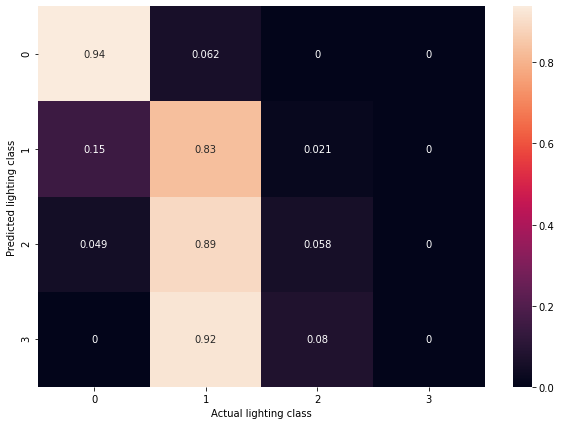

In [35]:
df_cm = pd.DataFrame(cm, index = sorted(list(set(y_true))), columns = sorted(list(set(y_true))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel("Actual lighting class")
plt.ylabel("Predicted lighting class")
plt.savefig('13BinConfusion.png')

## Integrated Gradients

In [36]:
import PIL
from PIL import Image


import torchvision
from torchvision import models
from torchvision import transforms

from matplotlib.colors import LinearSegmentedColormap



from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [37]:
#Create a iterable list of inputs to pass into Integrated Gradients Model
lst_inputs = []
all_images = X_IG[all_randomidx, :, :, :]
print(all_images.shape)

# for tensr_image in all_images :
#     input = torch.tensor(tensr_image)
#     input = input.unsqueeze(0)
#     lst_inputs.append(np.transpose(input, (0, 3, 1, 2)))
#     print(np.transpose(input, (0, 3, 1, 2)).shape)

(120, 4, 32, 32)


In [45]:
#Compute the model output for all the inputs in the input list
from collections import defaultdict
predicted_dict = defaultdict(list)
total_outputs = []
for idx, input1 in enumerate(all_images):
    input1 = torch.tensor(input1)
    input1= input1.unsqueeze(0)
    output = model(input1)
    output = F.softmax(output, dim =1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    predicted_dict[pred_label_idx.item()].append(idx)
    total_outputs.append(output)

In [81]:
#Initialize the integrated gradients model and run it for each of the inputs
# with respect to each of the picture's predicted class (target is set to label of predicted class)
integrated_gradients = IntegratedGradients(model)
attributions_mult = []
print(len(attributions_mult))
for idx, input1 in enumerate(all_images):
    input1 = torch.tensor(input1)
    input1 = input1.unsqueeze(0)
    prediction_score, pred_label_idx = torch.topk(total_outputs[idx], 1)
    attributions_ig = integrated_gradients.attribute(input1, target = pred_label_idx, n_steps= 250)
    attributions_mult.append(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)))
attributions_mult = np.array(attributions_mult)

0


In [82]:
print(attributions_mult.shape, np.transpose(all_images, (0, 2, 3, 1)).shape)

(120, 32, 32, 4) (120, 32, 32, 4)


### Various plots depicting attributions against various parameters

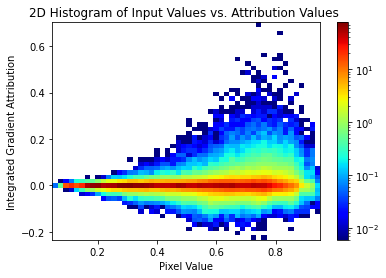

In [83]:
#Create a 2D histogram of the pixel values against the attributions for the attributions

import matplotlib.cm, matplotlib.colors
samp_all= np.transpose(all_images, (0, 2, 3, 1))
plt.xlabel("Pixel Value")
plt.ylabel("Integrated Gradient Attribution")
plt.title("2D Histogram of Input Values vs. Attribution Values ")
hi_ = plt.hist2d(samp_all.flatten(), attributions_mult.flatten(), density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
plt.colorbar()
plt.savefig("inputAttributions_igeven.png")
plt.show()


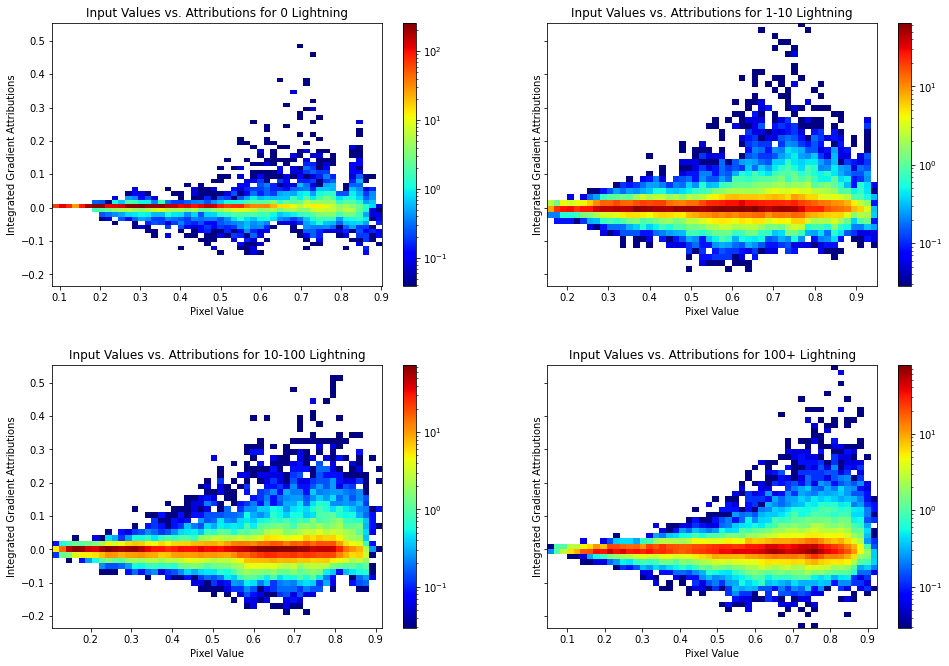

In [174]:
## 2-d Histograms showing how input values as well as attributions vary acrosss true bins
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
classifications = ['0 Lightning', '1-10 Lightning', '10-100 Lightning', '100+ Lightning']

it = 0
for i in range(2):
    for j in range (2):
        axs[i, j].set_title("Input Values vs. Attributions for " +
                            classifications[it])
        axs[i,j].set_xlabel("Pixel Value")
        axs[i,j].set_ylabel("Integrated Gradient Attributions")
        hi_ = axs[i,j].hist2d(samp_all[random_size*(it):random_size+random_size*(it), :, :, :].flatten(), 
                              attributions_mult[random_size *(it):random_size+random_size*(it), :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
        ax = axs[i,j]
        fig.colorbar(hi_[3], ax = ax)
        it += 1

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

plt.show()

In [92]:
print(attributions_mult[predicted_dict[0], :, :, :].shape, attributions_mult[predicted_dict[1], :, :, :].shape)
print(len(predicted_dict))


(30, 32, 32, 4) (85, 32, 32, 4)
3


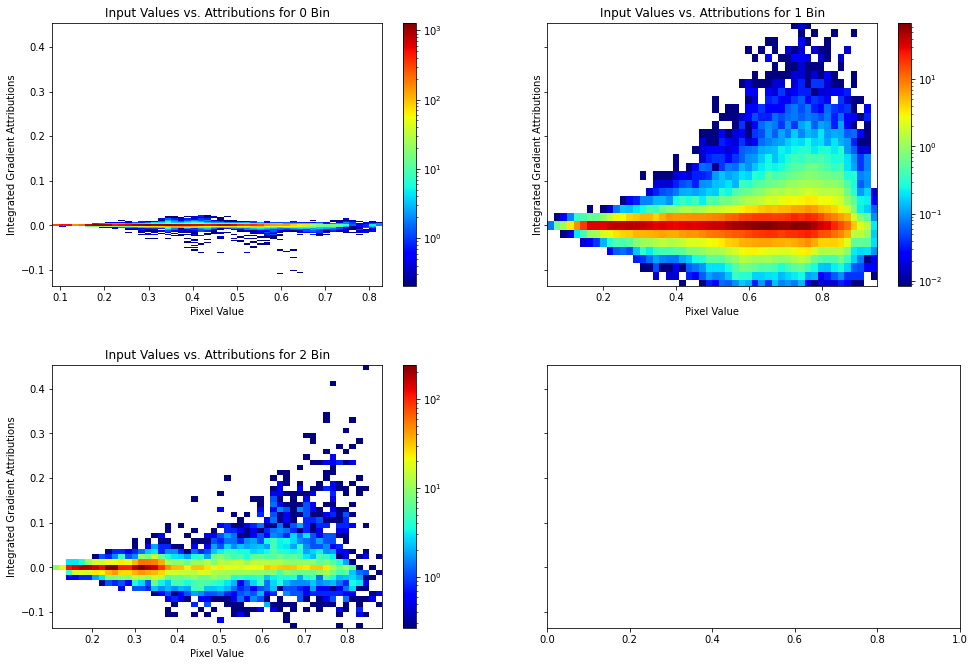

In [62]:
## 2-d Histograms showing how input values as well as attributions vary acrosss predicted bins
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
classifications = ['0 Bin', '1 Bin', '2 Bin', '3 Bin']

it = 0
for i in range(2):
    for j in range (2):
        if(it == len(predicted_dict)):
           break
        axs[i, j].set_title("Input Values vs. Attributions for " +
                            classifications[it])
        axs[i,j].set_xlabel("Pixel Value")
        axs[i,j].set_ylabel("Integrated Gradient Attributions")
        hi_ = axs[i,j].hist2d(samp_all[predicted_dict[it], :, :, :].flatten(), 
                              attributions_mult[predicted_dict[it], :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
        ax = axs[i,j]
        fig.colorbar(hi_[3], ax = ax)
        it += 1
    else:
        continue
    break
    

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

plt.show()

#### An example of standard Integrated Gradients from a bin 3 image ()

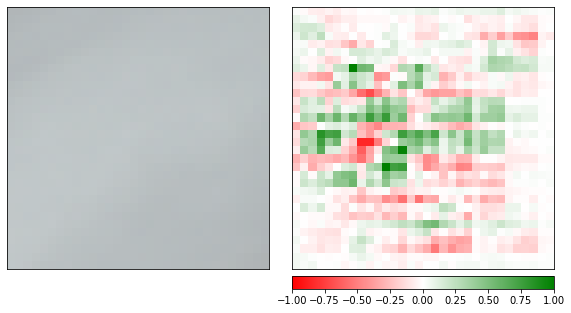

In [107]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(attributions_mult[88,:,:, :],
                                          samp_all[88,:, :, :],
                                          ["original_image", "heat_map"],
                                          ["all", "all"],
                                          show_colorbar=True,
                                            outlier_perc=1)


In [67]:
print(samp_all[k, :, :, i:i+1].shape, attributions_mult[k,:,:, i:i+1].shape)

(32, 32, 1) (32, 32, 1)


In [205]:
def attributions_visualization (attributions, image, cmap=None, curr_class=""):
    fig, axs = plt.subplots(nrows=4, ncols=2, squeeze=False, figsize=(16, 16))
#     fig.subplots_adjust(wspace=0.01)
    
    axs[0, 0].set_title('Band 8 Image')
    _ = axs[0, 0].imshow(image[:, :, 0], vmin = 0, vmax = 1)
    fig.colorbar(_, ax = axs[0, 0])
    axs[0, 0].axis('off')

    
    axs[0, 1].set_title('Band 8 Attributions')
    _ =axs[0, 1].imshow(attributions[:, :, 0],cmap=plt.cm.jet, vmin = -.5, vmax = 0.5)
    fig.colorbar(_, ax = axs[0, 1])
    axs[0, 1].axis('off')

    
    axs[1, 0].set_title('Band 9 Image')
    _ = axs[1, 0].imshow(image[:, :, 1], vmin = 0, vmax = 1)
    fig.colorbar(_, ax = axs[1, 0])
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Band 9 Attributions')
    _ = axs[1, 1].imshow(attributions[:, :, 1],cmap=plt.cm.jet, vmin = -.5, vmax = 0.5)
    fig.colorbar(_, ax = axs[1, 1])
    axs[1, 1].axis('off')

    axs[2, 0].set_title('Band 10 Image')
    _ = axs[2, 0].imshow(image[:, :, 2], vmin = 0, vmax = 1)
    fig.colorbar(_, ax = axs[2, 0])
    axs[2, 0].axis('off')

    axs[2, 1].set_title('Band 10 Attributions')
    _ = axs[2, 1].imshow(attributions[:, :, 2],cmap=plt.cm.jet, vmin = -.5, vmax = 0.5)
    fig.colorbar(_, ax = axs[2, 1])
    axs[2, 1].axis('off')
    
    axs[3, 0].set_title('Band 14 Image')
    _ = axs[3, 0].imshow(image[:, :, 3], vmin = 0, vmax = 1)
    fig.colorbar(_, ax = axs[3, 0])
    axs[3, 0].axis('off')

 
    axs[3, 1].set_title('Band 14 Attributions')
    _ = axs[3, 1].imshow(attributions[:, :, 3],cmap=plt.cm.jet, vmin = -.5, vmax = 0.5)
    fig.colorbar(_, ax = axs[3, 1])
    axs[3, 1].axis('off')
    
    plt.tight_layout()
 
#     fig.suptitle(curr_class, ha= "center")
    
  
#     print(fig.shape)
    return fig
    

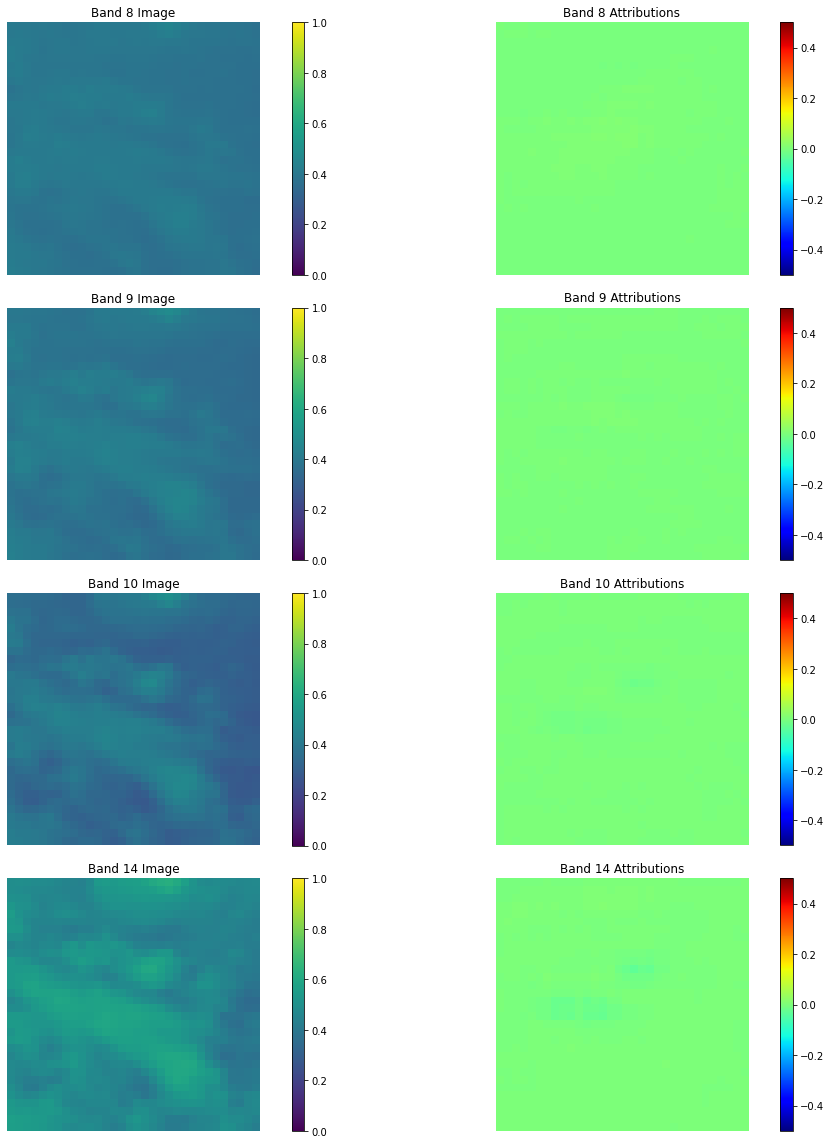

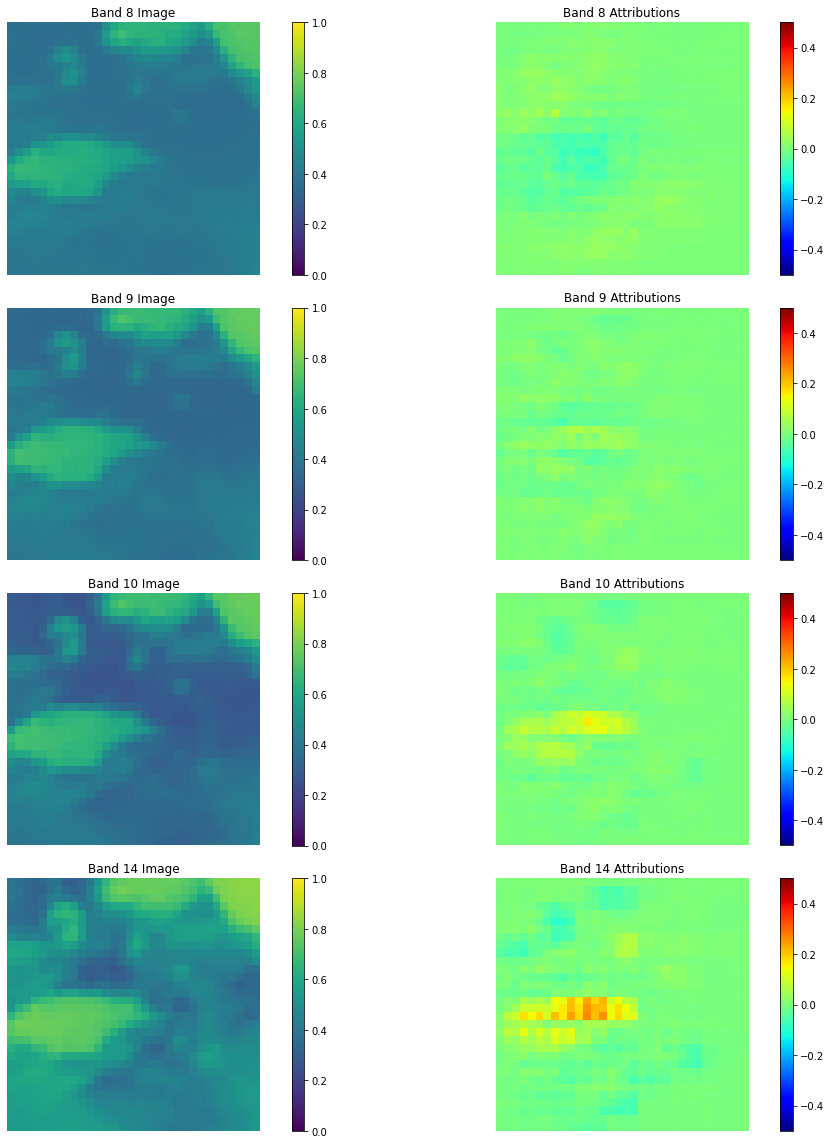

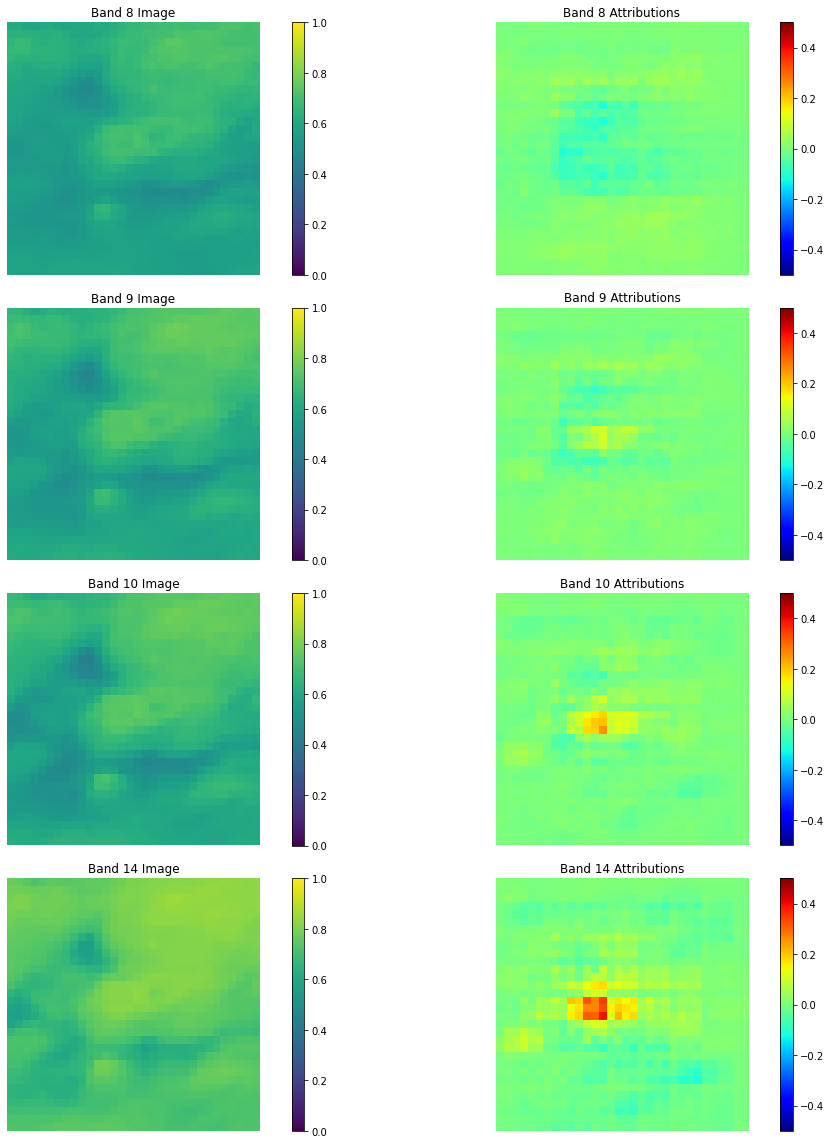

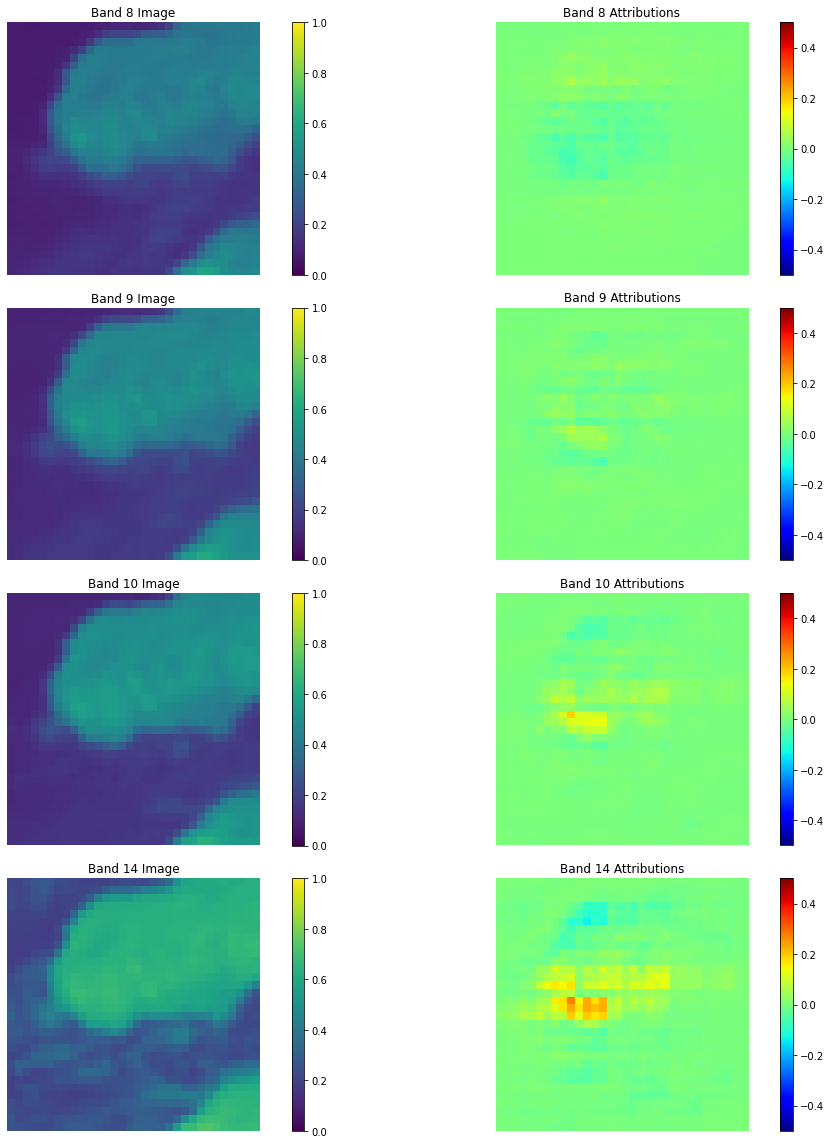

In [206]:
_ = attributions_visualization(attributions_mult[11], samp_all[11], curr_class=" 0 Lightning Count")
_ = attributions_visualization(attributions_mult[48], samp_all[48],  curr_class=" 1-9 Lightning Count")
_ = attributions_visualization(attributions_mult[77], samp_all[77],  curr_class=" 10-99 Lightning Count")
_ = attributions_visualization(attributions_mult[111], samp_all[111],  curr_class=" 100+ Lightning Count")

In [109]:
samp_all[k][:, :, 1:2].shape

(32, 32, 1)

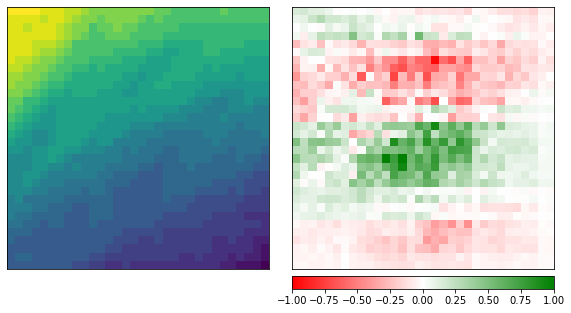

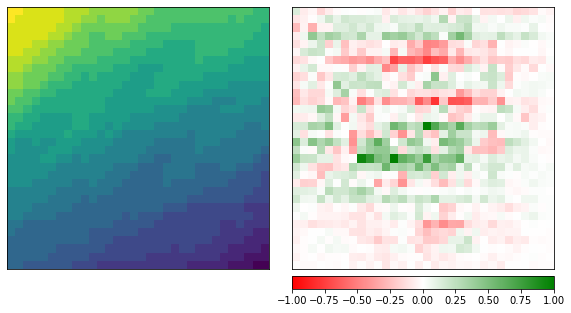

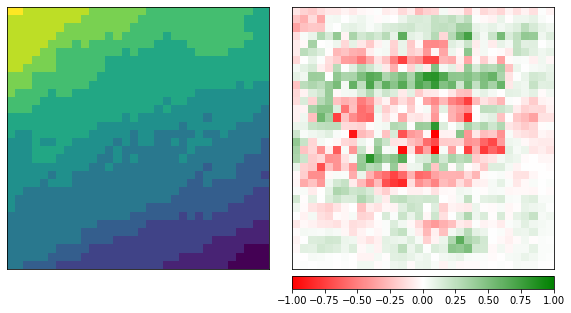

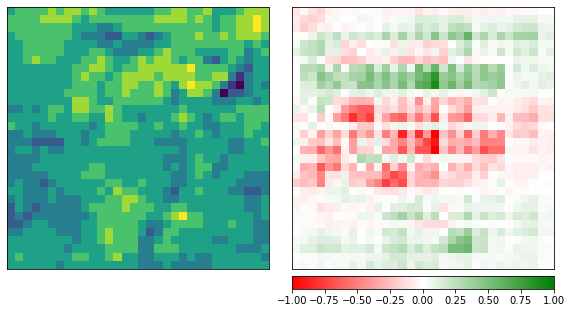

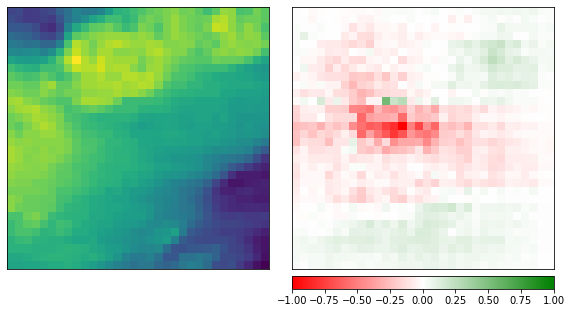

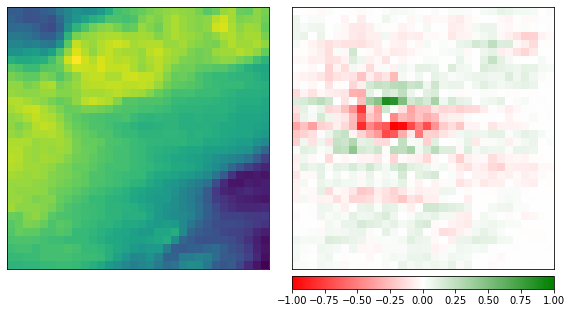

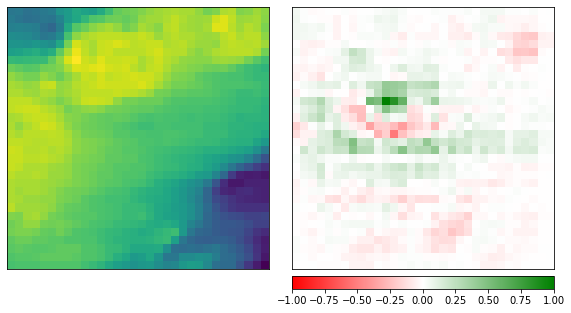

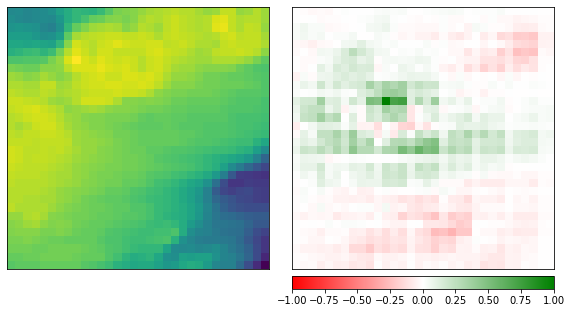

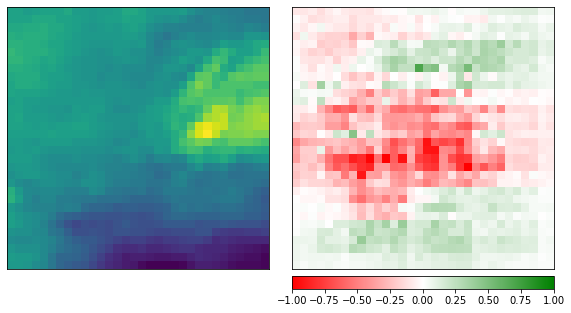

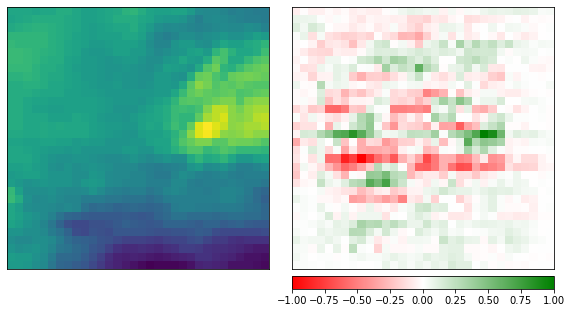

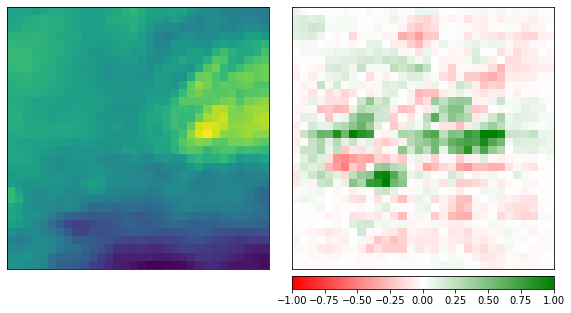

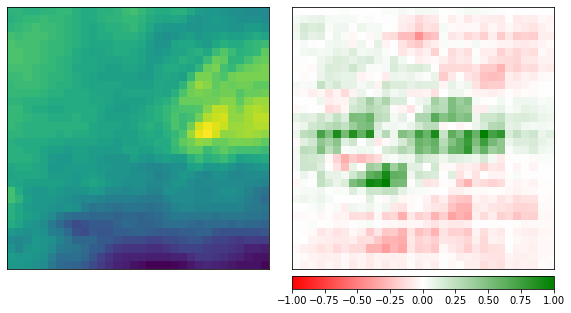

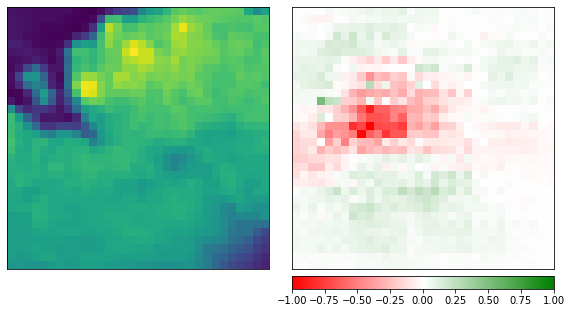

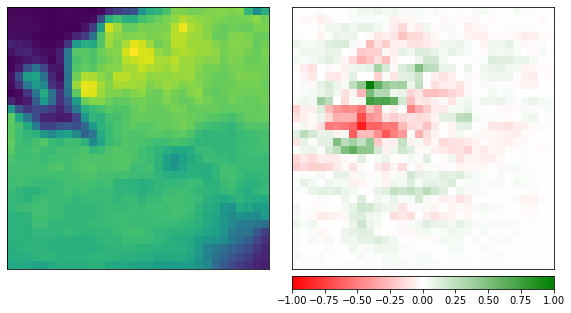

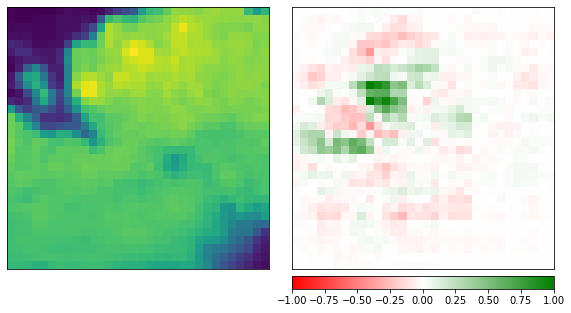

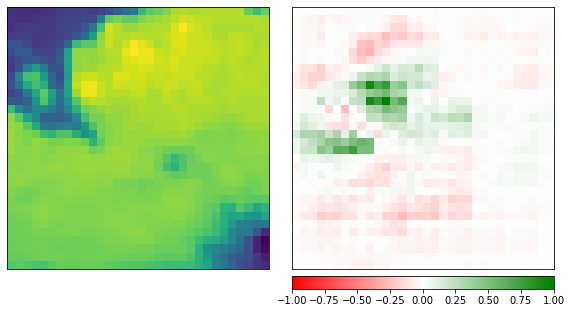

In [161]:
for k in ([27, 44, 81, 103]):
    for i in range(4):
        _ = viz.visualize_image_attr_multiple(attributions_mult[k,:,:, i:i+1],
                                          samp_all[k,:, :, i:i+1],
                                          ["original_image", "heat_map"],
                                          ["all", "all"],
                                          show_colorbar=True,
                                            outlier_perc=1)


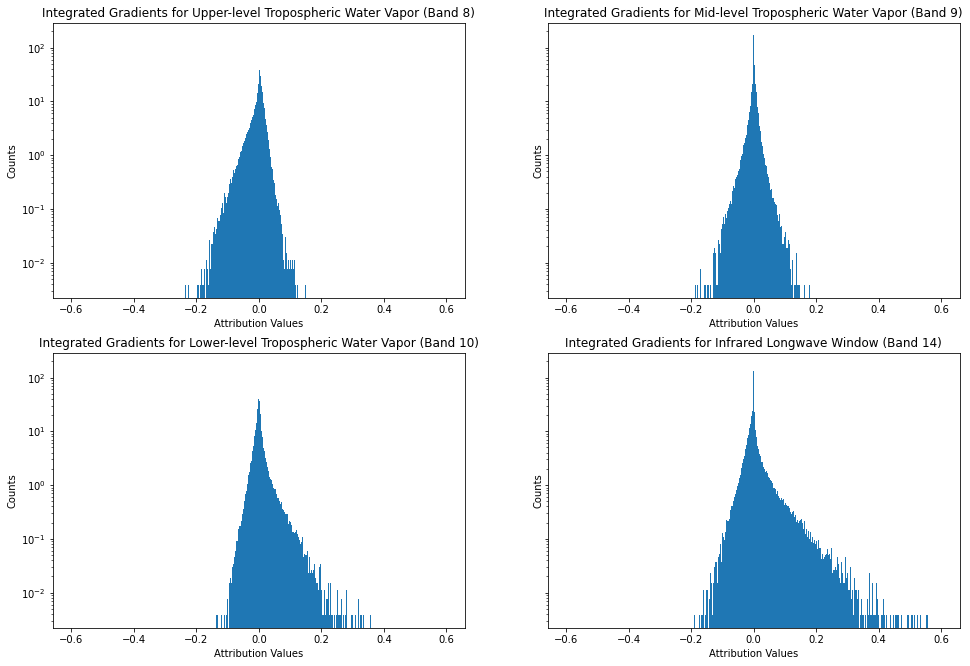

In [71]:
#Attributions Plotting for the four bands
attributions_channels = attributions_mult.transpose(3, 1, 2, 0)
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
attributions_channels.shape
l =["Upper-level Tropospheric Water Vapor (Band 8)", "Mid-level Tropospheric Water Vapor (Band 9)",
    "Lower-level Tropospheric Water Vapor (Band 10)", "Infrared Longwave Window (Band 14)"]
it = 0
histogram_store = []
for i in range(2):
    for j in range (2):
        attributions_channels[it].flatten()
        axs[i, j].set_title("Integrated Gradients for " + l[it] )
        axs[i,j].set_xlabel("Attribution Values")
        axs[i,j].set_ylabel("Counts")
        _ =axs[i, j].hist(attributions_channels[it].flatten(), bins = 557, density = True, range = (-0.6, 0.6), log=True)
        histogram_store.append(_[0])
        it += 1

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)
plt.savefig("atributions_channels")
plt.show()
    

### Repeat of previous analysis with the Baseline set to the average bin 0 image

In [84]:
integrated_gradients = IntegratedGradients(model)
attributionsBase_mult = []

for input1 in all_images:
    input1 = torch.tensor(input1)
    input1 = input1.unsqueeze(0)
    prediction_score, pred_label_idx = torch.topk(total_outputs[idx], 1)
    attributionsBase_ig = integrated_gradients.attribute(input1, target = pred_label_idx, n_steps = 250, baselines= base_zero.unsqueeze(0) )
    attributionsBase_mult.append(np.transpose(attributionsBase_ig.squeeze().cpu().detach().numpy(), (1,2,0)))
attributionsBase_mult = np.array(attributionsBase_mult)

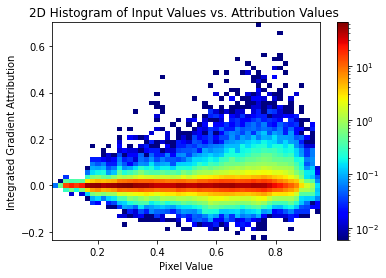

In [86]:
plt.xlabel("Pixel Value")
plt.ylabel("Integrated Gradient Attribution")
plt.title("2D Histogram of Input Values vs. Attribution Values ")
hi_ = plt.hist2d(samp_all.flatten(), attributionsBase_mult.flatten(), density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()


In [87]:
attributionsBase_mult.shape

(120, 32, 32, 4)

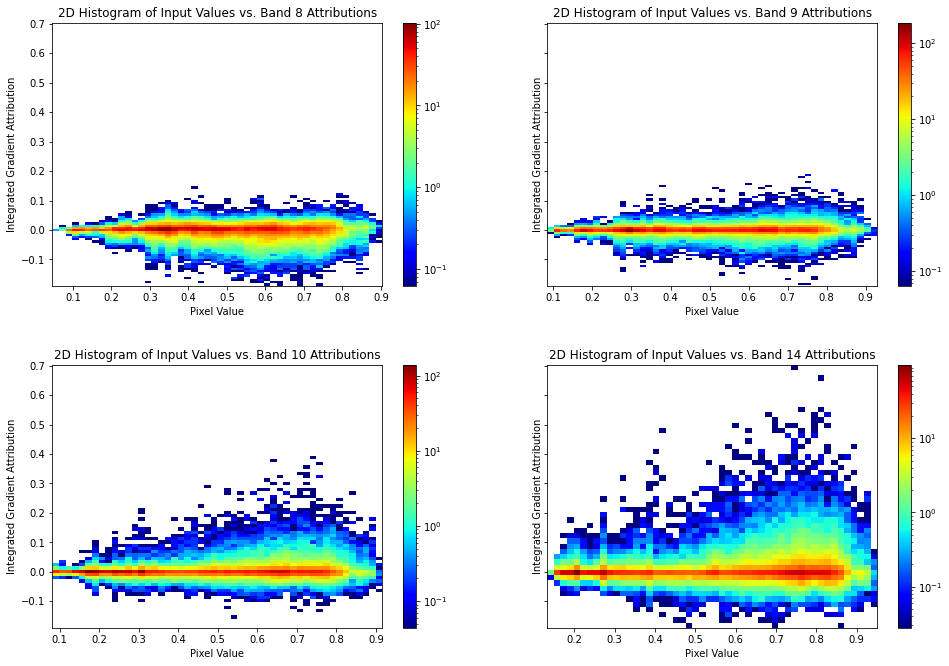

In [88]:
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
l =["Band 8 Attributions", "Band 9 Attributions",
    "Band 10 Attributions", "Band 14 Attributions"]

it = 0
for i in range(2):
    for j in range (2):
        axs[i, j].set_title("2D Histogram of Input Values vs. " + l[it] )
        axs[i,j].set_xlabel("Pixel Value")
        axs[i,j].set_ylabel("Integrated Gradient Attribution")
        hi_ = axs[i,j].hist2d(samp_all[:, :, :, it].flatten(), attributionsBase_mult[:, :, :, it].flatten(), density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
        ax = axs[i,j]
        fig.colorbar(hi_[3], ax = ax)
        it += 1

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)
plt.savefig("bandwise2d.png")
plt.show()

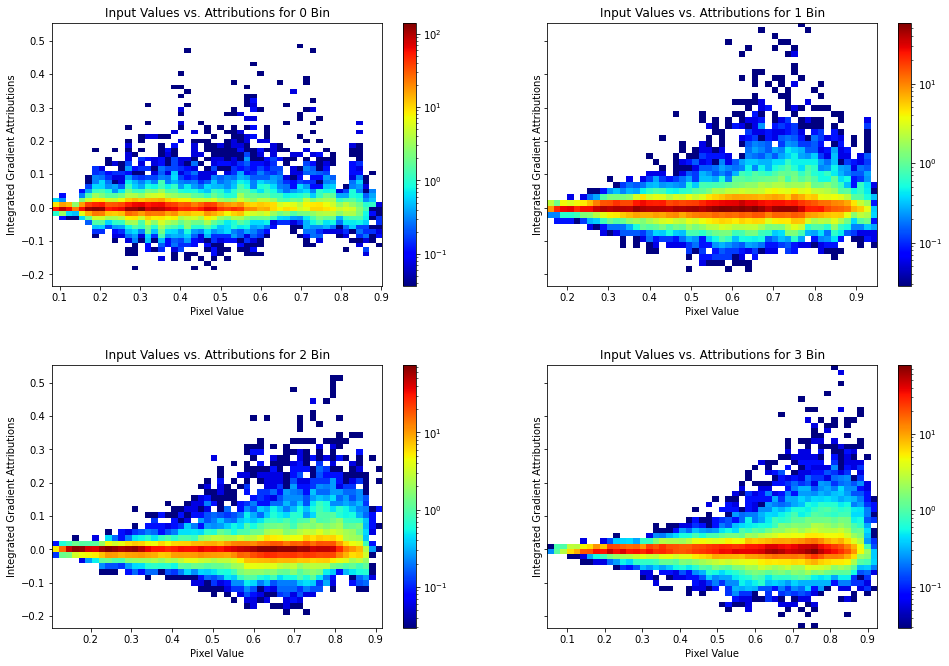

In [89]:
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
classifications = ['0 Bin', '1 Bin', '2 Bin', '3 Bin']

it = 0
for i in range(2):
    for j in range (2):
        axs[i, j].set_title("Input Values vs. Attributions for " +
                            classifications[it])
        axs[i,j].set_xlabel("Pixel Value")
        axs[i,j].set_ylabel("Integrated Gradient Attributions")
        hi_ = axs[i,j].hist2d(samp_all[random_size*(it):random_size+random_size*(it), :, :, :].flatten(), 
                              attributionsBase_mult[random_size *(it):random_size+random_size*(it), :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
        ax = axs[i,j]
        fig.colorbar(hi_[3], ax = ax)
        it += 1

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

plt.show()

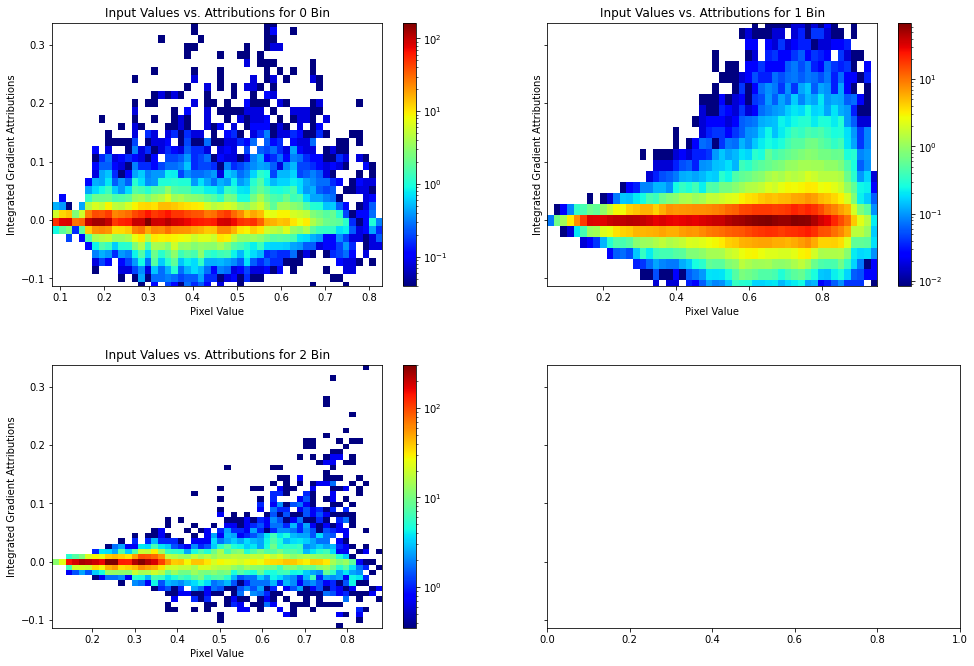

In [90]:
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
classifications = ['0 Bin', '1 Bin', '2 Bin', '3 Bin']

it = 0
for i in range(2):
    for j in range (2):
        if(it == len(predicted_dict)):
           break
        axs[i, j].set_title("Input Values vs. Attributions for " +
                            classifications[it])
        axs[i,j].set_xlabel("Pixel Value")
        axs[i,j].set_ylabel("Integrated Gradient Attributions")
        hi_ = axs[i,j].hist2d(samp_all[predicted_dict[it], :, :, :].flatten(), 
                              attributionsBase_mult[predicted_dict[it], :, :, :].flatten(),
                              density = True, bins= (50, 50), cmap = plt.cm.jet, norm = matplotlib.colors.LogNorm())
        ax = axs[i,j]
        fig.colorbar(hi_[3], ax = ax)
        it += 1
    else:
        continue
    break
    

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

plt.show()

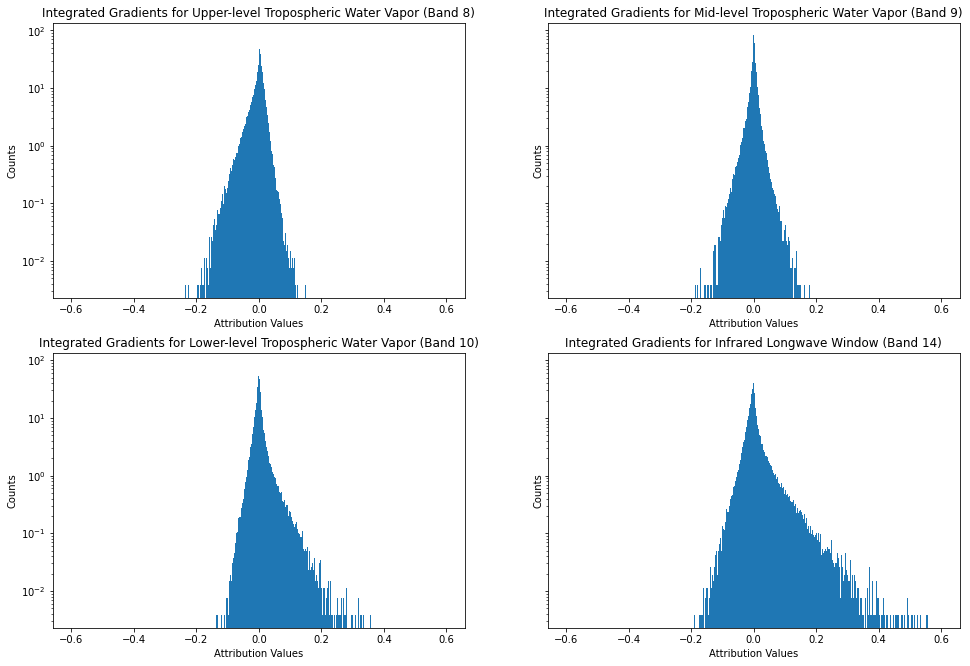

In [91]:
attributions_channels = attributionsBase_mult.transpose(3, 1, 2, 0)
fig, axs = plt.subplots(2, 2, figsize = (18,12), sharey = True)
attributions_channels.shape
l =["Upper-level Tropospheric Water Vapor (Band 8)", "Mid-level Tropospheric Water Vapor (Band 9)",
    "Lower-level Tropospheric Water Vapor (Band 10)", "Infrared Longwave Window (Band 14)"]
it = 0
histogram_store = []
for i in range(2):
    for j in range (2):
        attributions_channels[it].flatten()
        axs[i, j].set_title("Integrated Gradients for " + l[it] )
        axs[i,j].set_xlabel("Attribution Values")
        axs[i,j].set_ylabel("Counts")
        _ =axs[i, j].hist(attributions_channels[it].flatten(), bins = 557, density = True, log=True, range=(-0.6, 0.6))
        histogram_store.append(_[0])
        it += 1

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)
plt.show()